In [1]:
import glob
for path in glob.glob("**/data.mat", recursive=True):
    print(path)


exp/datasets/anes_data/simu/1/data.mat
exp/datasets/anes_data/simu/2/data.mat
exp/datasets/anes_data/simu/3/data.mat
exp/datasets/anes_data/simu/4/data.mat
exp/datasets/anes_data/vivo/data.mat


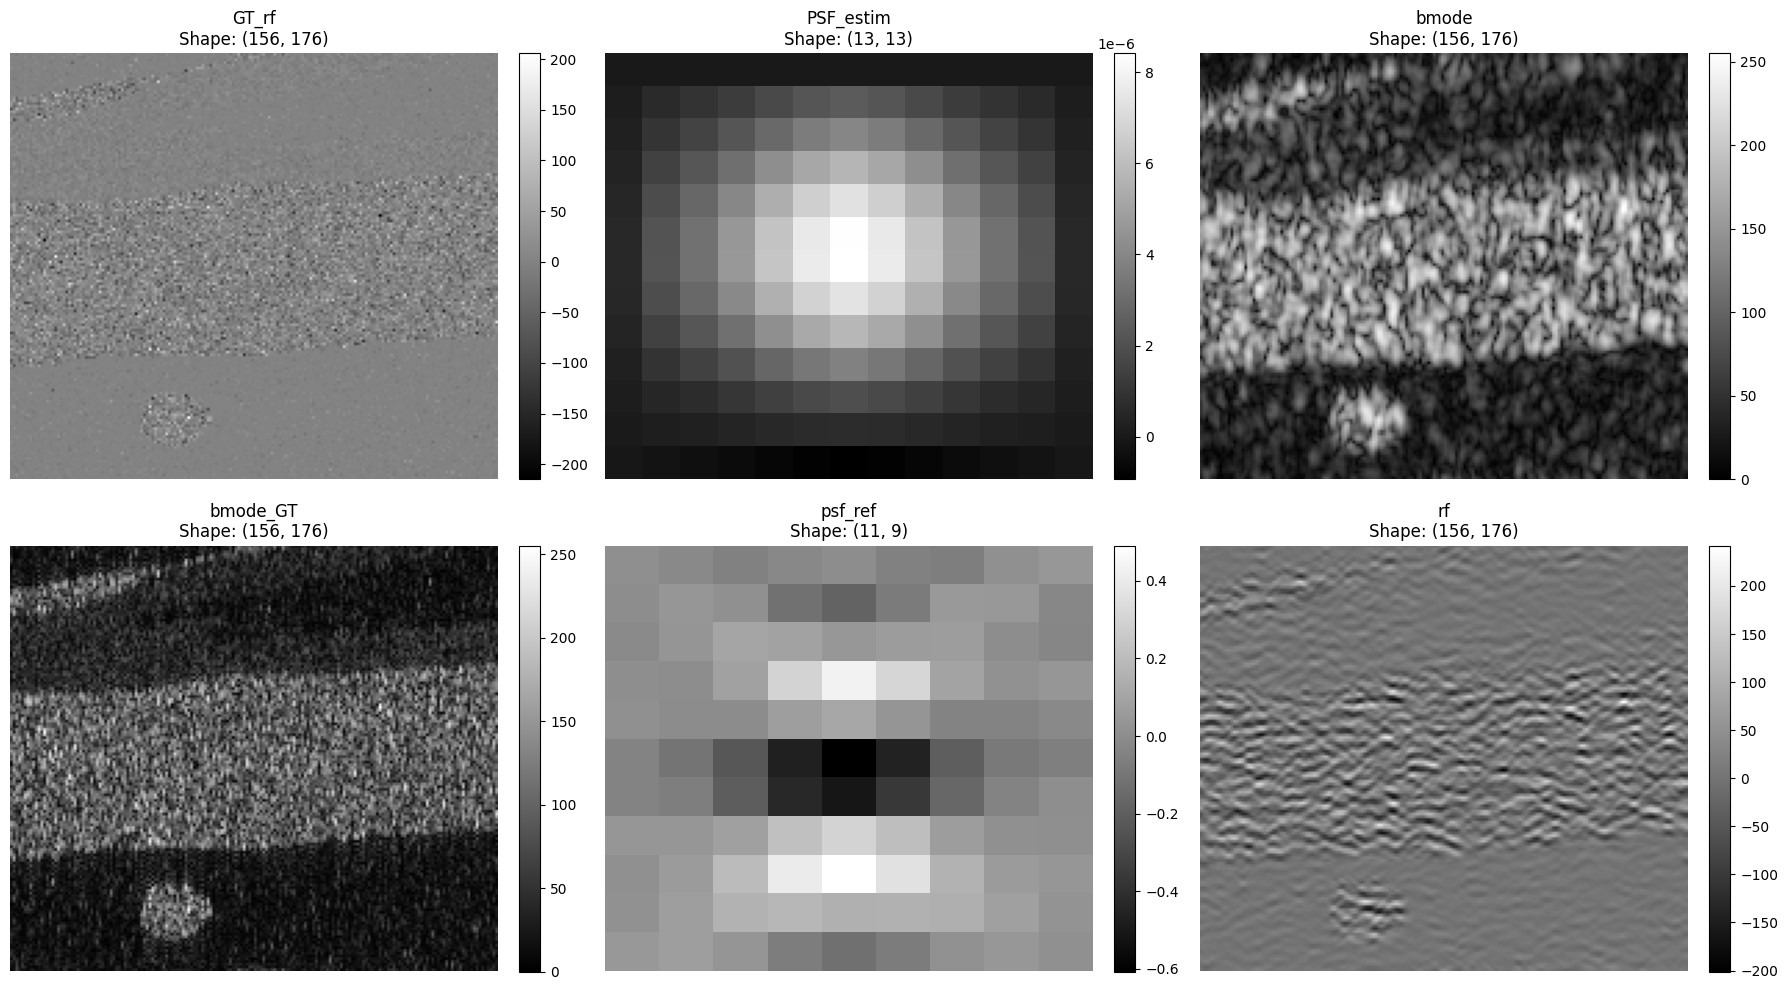

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Load .mat file
mat_path = "exp/datasets/anes_data/simu/1/data.mat"
mat_data = scipy.io.loadmat(mat_path)

# List of variable names to plot
variables_to_plot = ['GT_rf', 'PSF_estim', 'bmode', 'bmode_GT', 'psf_ref', 'rf']

# Create 2 rows × 3 columns subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables_to_plot):
    ax = axes[i]
    
    if var not in mat_data:
        ax.set_title(f"{var} (Not Found)")
        ax.axis('off')
        continue

    data = mat_data[var]
    
    # Slice third dimension if 3D
    if data.ndim == 3:
        img = data[:, :, 0]
    else:
        img = data

    im = ax.imshow(img, cmap='gray', aspect='auto')
    ax.set_title(f"{var}\nShape: {data.shape}")
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


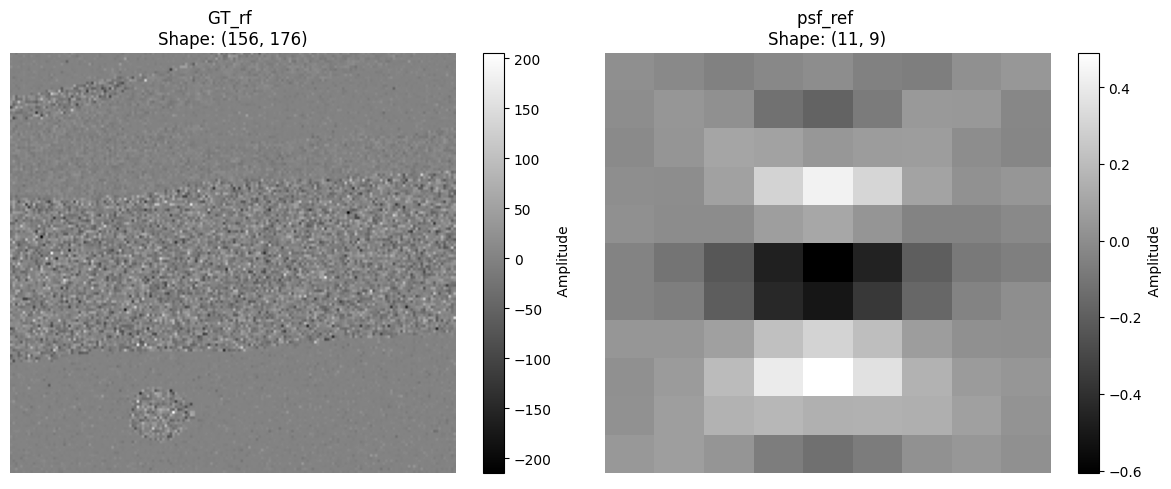

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

# Load .mat file
mat_path = "exp/datasets/anes_data/simu/1/data.mat"
mat_data = scipy.io.loadmat(mat_path)

# Extract data
gt_rf = mat_data["GT_rf"]
psf_ref = mat_data["psf_ref"]



# Plot side-by-side
plt.figure(figsize=(12, 5))

# --- GT_rf ---
plt.subplot(1, 2, 1)
plt.imshow(gt_rf, cmap='gray', aspect='auto')
plt.title(f"GT_rf \nShape: {gt_rf.shape}")
plt.colorbar(label=' Amplitude')
plt.axis('off')

# --- psf_ref ---
plt.subplot(1, 2, 2)
plt.imshow(psf_ref, cmap='gray', aspect='auto')
plt.title(f"psf_ref \nShape: {psf_ref.shape}")
plt.colorbar(label=' Amplitude')
plt.axis('off')

plt.tight_layout()
plt.show()


✅ Resized  RF GT saved to: input/Simu/1/resized_rf_gt.mat


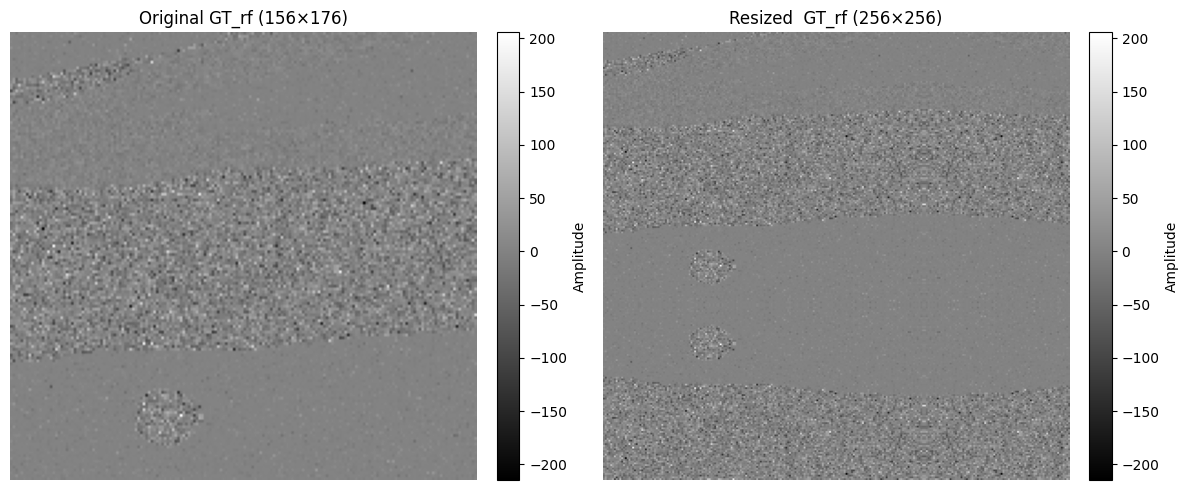

In [5]:
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt

# Step 1: Load original RF data
mat_path = "exp/datasets/anes_data/simu/1/data.mat"
data = scipy.io.loadmat(mat_path)
gt_rf = data['GT_rf']  # Shape: (156, 176)

# Step 2: Resize to 256x256 using mirroring
target_h, target_w = 256, 256
h, w = gt_rf.shape

gt_rf_resized = gt_rf.copy()
while gt_rf_resized.shape[1] < target_w:
    to_add = np.fliplr(gt_rf_resized)[:, :min(target_w - gt_rf_resized.shape[1], w)]
    gt_rf_resized = np.concatenate((gt_rf_resized, to_add), axis=1)

while gt_rf_resized.shape[0] < target_h:
    to_add = np.flipud(gt_rf_resized)[:min(target_h - gt_rf_resized.shape[0], h), :]
    gt_rf_resized = np.concatenate((gt_rf_resized, to_add), axis=0)



# Step 4: Save resized  RF
output_dir = "input/Simu/1"
os.makedirs(output_dir, exist_ok=True)
save_path = os.path.join(output_dir, "resized_rf_gt.mat")
scipy.io.savemat(save_path, {"GT_rf_resized": gt_rf_resized})
print(f"✅ Resized  RF GT saved to: {save_path}")

# Step 5: Visualization function
def show_rf_with_colorbar(data, title, ax):
    img = ax.imshow(data, cmap='gray', aspect='auto')
    ax.set_title(title)
    ax.axis('off')
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04, label="Amplitude")

# Step 6: Plot original and resized RF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
show_rf_with_colorbar(gt_rf, f"Original GT_rf ({h}×{w})", axes[0])
show_rf_with_colorbar(gt_rf_resized, "Resized  GT_rf (256×256)", axes[1])

plt.tight_layout()
plt.show()


In [6]:
print(gt_rf_resized.shape)

(256, 256)


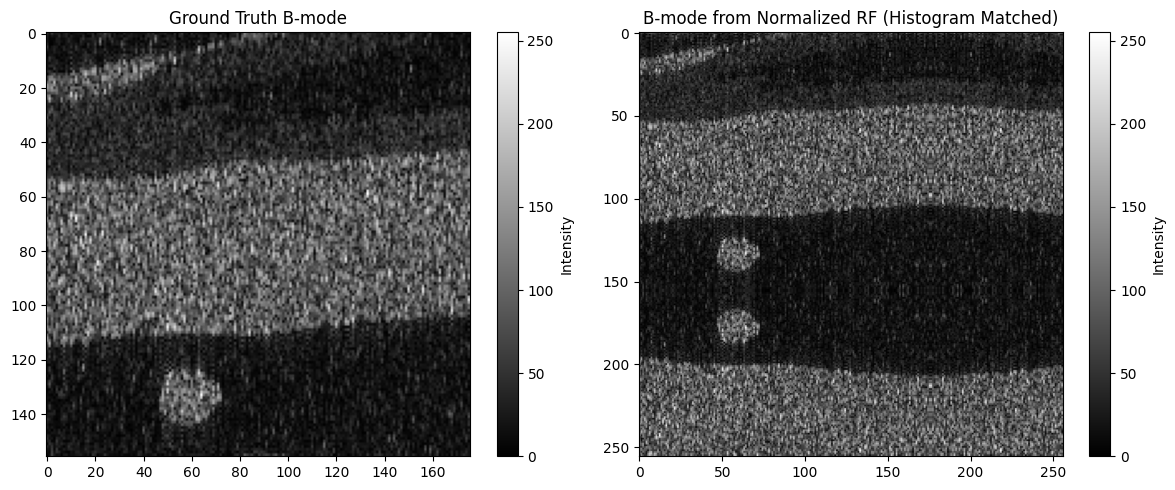

In [7]:
from skimage.exposure import match_histograms
from scipy.signal import hilbert

# Load GT B-mode for histogram reference
gt_bmode = mat_data["bmode_GT"]

# Redefine the rf_to_matched_bmode function
def rf_to_matched_bmode(RF: np.ndarray, GT_bmode: np.ndarray, increase: float = 1e-6) -> np.ndarray:
    env = np.abs(hilbert(RF, axis=0))
    db  = 20.0 * np.log10(env + increase)
    db  = np.clip(db, a_min=-60, a_max=None)
    db -= db.min()
    db *= (255.0 / db.max())
    ref = GT_bmode[:, :, 0] if GT_bmode.ndim == 3 else GT_bmode
    matched = match_histograms(db, ref, channel_axis=None)
    return np.clip(matched, 0, 255).astype(np.uint8)

# Apply B-mode conversion with histogram matching
matched_bmode = rf_to_matched_bmode(gt_rf_resized, gt_bmode)

# Visualize matched B-mode and ground truth B-mode side-by-side
plt.figure(figsize=(12, 5))

# Ground truth B-mode
plt.subplot(1, 2, 1)
plt.imshow(gt_bmode, cmap='gray', aspect='auto')
plt.title("Ground Truth B-mode")
plt.colorbar(label='Intensity')

# Histogram matched B-mode
plt.subplot(1, 2, 2)
plt.imshow(matched_bmode, cmap='gray', aspect='auto')
plt.title("B-mode from Normalized RF (Histogram Matched)")
plt.colorbar(label='Intensity')

plt.tight_layout()
plt.show()


✅ Saved degraded RF with BCCB + noise to input/Simu/1/degraded_y0.mat


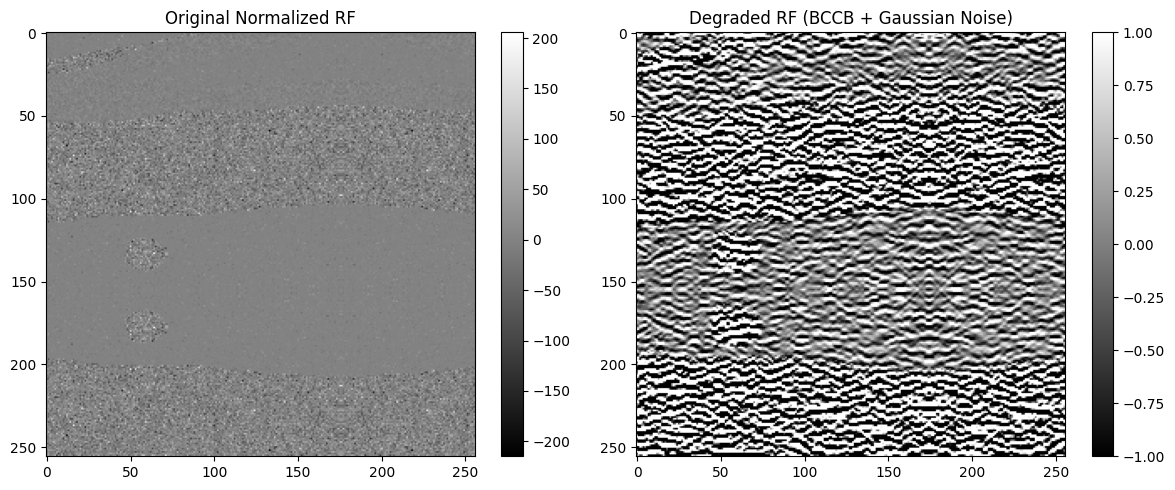

In [8]:
import numpy as np
import scipy.io
from numpy.fft import fft2, ifft2, fftshift
import matplotlib.pyplot as plt

# === Load normalized resized RF and PSF ===
rf_data = scipy.io.loadmat("input/Simu/1/resized_rf_gt.mat")  # (256, 256)
gt_rf = rf_data["GT_rf_resized"]

psf_data = scipy.io.loadmat("exp/datasets/anes_data/simu/1/data.mat")
psf = psf_data["psf_ref"]
psf = psf / (np.sum(np.abs(psf)) + 1e-8)  # Normalize PSF

# === Pad and center PSF to match RF size ===
H, W = gt_rf.shape
psf_padded = np.zeros((H, W), dtype=np.float32)
ph, pw = psf.shape
psf_padded[:ph, :pw] = psf

# Center the PSF in the frequency domain
psf_padded = np.roll(np.roll(psf_padded, -ph // 2, axis=0), -pw // 2, axis=1)

# === FFT of the PSF (for BCCB convolution) ===
H_fft = fft2(psf_padded)

# === Degrade the RF using BCCB convolution ===
Y_fft = H_fft * fft2(gt_rf)
y = np.real(ifft2(Y_fft))

# === Add Gaussian noise ===
noise_std = 0.003508  # Set SNR here
noise = np.random.normal(0, noise_std, size=y.shape).astype(np.float32)
y_noisy = y + noise

# === Save degraded RF ===
scipy.io.savemat("input/Simu/1/degraded_y0.mat", {"rf_degraded": y_noisy})
print("✅ Saved degraded RF with BCCB + noise to input/Simu/1/degraded_y0.mat")

# === Visualize original vs degraded ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gt_rf, cmap='gray', aspect='auto')
plt.title("Original Normalized RF")
plt.colorbar()

plt.subplot(1, 2, 2)
y_noisy = np.clip(y_noisy, -1.0, 1.0)
plt.imshow(y_noisy, cmap='gray', aspect='auto')
plt.title("Degraded RF (BCCB + Gaussian Noise)")
plt.colorbar()

plt.tight_layout()
plt.show()


In [11]:
import os

# Define the target folder
target_folder = "input/Simu/1"
os.makedirs(target_folder, exist_ok=True)

# Path to mat_list.txt
mat_list_path = os.path.join(target_folder, "mat_list.txt")

# Write the filename to the text file
with open(mat_list_path, "w") as f:
    f.write("resized_rf_gt.mat\n")

print(f" 'mat_list.txt' created at: {mat_list_path}")

 'mat_list.txt' created at: input/Simu/1/mat_list.txt


In [12]:
import os

# Define the target folder and file names
target_folder = "input/Simu/1"
mat_filename = "resized_rf_gt.mat"
mat_list_path = os.path.join(target_folder, "mat_list.txt")
mat_file_path = os.path.join(target_folder, mat_filename)

# Step 1: Ensure the target directory exists
os.makedirs(target_folder, exist_ok=True)

# Step 2: Write the filename to mat_list.txt
with open(mat_list_path, "w") as f:
    f.write(mat_filename + "\n")

print(f" 'mat_list.txt' created at: {mat_list_path}")

# Step 3: Verify that the .mat file exists
if os.path.isfile(mat_file_path):
    print(f" Found required .mat file: {mat_file_path}")
else:
    print(f" WARNING: '{mat_filename}' does NOT exist in {target_folder}.")

 'mat_list.txt' created at: input/Simu/1/mat_list.txt
 Found required .mat file: input/Simu/1/resized_rf_gt.mat


In [13]:
!python apply_degradation.py \
  --mat_dir input/Simu/1 \
  --mat_list input/Simu/1/mat_list.txt \
  --psf_path exp/datasets/anes_data/simu/1/psf_GT_1.mat \
  --output_dir input/Simu/1/ddrm_out_without_norm \
  --key GT_rf_resized \
  --image_size 256 \
  --sigma_0 0.01

Using device: cuda
✅ Found PSF key: psf_ref
✅ Saved:
   • ground_truth.mat   (GT_rf_resized)
   • degraded_y0.mat    (rf_degraded)
